Seed: 0, Participants: 2, Accuracy: 0.7210, F1 Score: 0.6868
Seed: 0, Participants: 3, Accuracy: 0.7098, F1 Score: 0.6905
Seed: 0, Participants: 4, Accuracy: 0.7120, F1 Score: 0.6714
Seed: 0, Participants: 5, Accuracy: 0.6950, F1 Score: 0.6743
Seed: 0, Participants: 6, Accuracy: 0.7103, F1 Score: 0.6833
Seed: 0, Participants: 7, Accuracy: 0.7067, F1 Score: 0.6594
Seed: 0, Participants: 8, Accuracy: 0.7013, F1 Score: 0.6499
Seed: 0, Participants: 9, Accuracy: 0.7017, F1 Score: 0.6657
Seed: 0, Participants: 10, Accuracy: 0.7035, F1 Score: 0.6494
Seed: 1, Participants: 2, Accuracy: 0.7318, F1 Score: 0.6849
Seed: 1, Participants: 3, Accuracy: 0.7076, F1 Score: 0.6865
Seed: 1, Participants: 4, Accuracy: 0.7098, F1 Score: 0.6714
Seed: 1, Participants: 5, Accuracy: 0.7058, F1 Score: 0.6683
Seed: 1, Participants: 6, Accuracy: 0.6955, F1 Score: 0.6243
Seed: 1, Participants: 7, Accuracy: 0.7013, F1 Score: 0.6831
Seed: 1, Participants: 8, Accuracy: 0.6973, F1 Score: 0.6530
Seed: 1, Participants: 

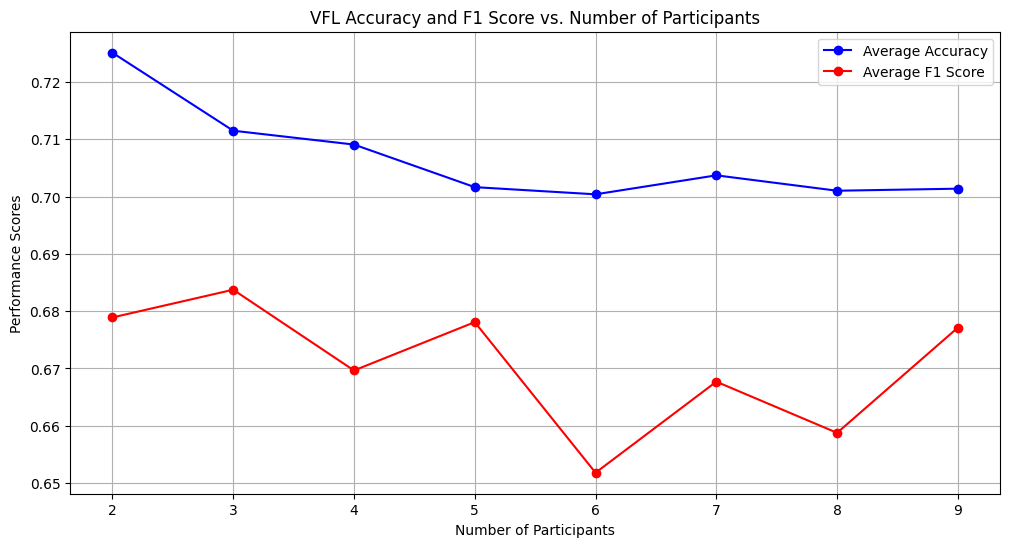

In [ ]:
#Prototype 1

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import random

# seeding for reproducibility
seed = 53
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset loading
df = pd.read_csv("/content/bank.csv")

# Data preprocessing steps
def preprocess_data(df):
    df = df.drop(columns=['duration'])
    label_encoders = {}
    binary_columns = ['default', 'housing', 'loan', 'deposit']
    for column in binary_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

df, label_encoders = preprocess_data(df)

# Vertical partition of the data
def vertical_partition(df, num_clients):
    partitions = [[] for _ in range(num_clients)]
    num_features = df.shape[1]
    for i, feature in enumerate(df.columns):
        participant = i % num_clients
        partitions[participant].append(feature)
    partitioned_dfs = [df[features] for features in partitions]
    return partitioned_dfs

# Train-Test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
y_train = train_df['deposit'].values
y_test = test_df['deposit'].values

# Dynamic participant setup
def prepare_data_for_participants(num_participants):
    train_partitions = vertical_partition(train_df.drop(columns=['deposit']), num_participants)
    test_partitions = vertical_partition(test_df.drop(columns=['deposit']), num_participants)

    for i in range(len(train_partitions)):
        train_partitions[i]['deposit'] = y_train
        test_partitions[i]['deposit'] = y_test

    for i in range(len(train_partitions)):
        train_partitions[i] = pd.get_dummies(train_partitions[i], drop_first=True)
        test_partitions[i] = pd.get_dummies(test_partitions[i], drop_first=True)

    for i in range(len(train_partitions)):
        train_partitions[i], test_partitions[i] = train_partitions[i].align(test_partitions[i], join='left', axis=1, fill_value=0)

    # Normalizition
    scaler = StandardScaler()
    for i in range(len(train_partitions)):
        feature_columns = train_partitions[i].columns.difference(['deposit'])
        train_partitions[i][feature_columns] = scaler.fit_transform(train_partitions[i][feature_columns])
        test_partitions[i][feature_columns] = scaler.transform(test_partitions[i][feature_columns])

    train_tensor_partitions = create_tensor_datasets(train_partitions)
    test_tensor_partitions = create_tensor_datasets(test_partitions)

    input_sizes = [partition.shape[1] - 1 for partition in train_partitions]
    return train_tensor_partitions, test_tensor_partitions, input_sizes

# Tensor datasets creation
def create_tensor_datasets(partitions):
    tensor_partitions = []
    for partition in partitions:
        partition = partition.apply(pd.to_numeric, errors='coerce').fillna(0)
        features = partition.drop(columns=["deposit"]).values
        labels = partition["deposit"].values.astype(np.int64)
        tensor_partition = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
        tensor_partitions.append(tensor_partition)
    return tensor_partitions

# Global Model
class GlobalModel(nn.Module):
    def __init__(self, input_sizes, hidden_sizes, output_size):
        super(GlobalModel, self).__init__()
        self.segments = nn.ModuleList()
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size)]
            self.segments.append(nn.Sequential(*layers))

    def forward(self, x, active_segments):
        segment_outputs = []
        start_index = 0
        for i, segment in enumerate(self.segments):
            end_index = start_index + input_sizes[i]
            if i in active_segments:
                segment_input = x[:, start_index:end_index]
                segment_output = segment(segment_input)
                segment_outputs.append(segment_output)
            else:
                segment_outputs.append(torch.zeros(x.size(0), output_size, device=x.device))
            start_index = end_index
        combined_output = torch.mean(torch.stack(segment_outputs), dim=0)
        return combined_output

# Training
def train(model, device, train_loader, optimizer, epoch, input_sizes, participant_id):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        padded_data = torch.zeros(data.size(0), sum(input_sizes)).to(device)
        start_index = sum(input_sizes[:participant_id])
        end_index = start_index + input_sizes[participant_id]
        padded_data[:, start_index:end_index] = data
        optimizer.zero_grad()
        output = model(padded_data, active_segments=[participant_id])
        loss = nn.CrossEntropyLoss(weight=class_weights)(output, target)
        loss.backward()
        optimizer.step()

# Gradient exchange function
def selective_exchange_gradients(models, input_sizes, hidden_sizes):
    num_models = len(models)
    param_indices = [0]
    cumulative_index = 0
    for i in range(len(hidden_sizes)):
        cumulative_index += (input_sizes[i] * hidden_sizes[i]) + hidden_sizes[i]
        param_indices.append(cumulative_index)

    for seg in range(len(hidden_sizes)):
        start = param_indices[seg]
        end = param_indices[seg + 1]
        for param_idx in range(start, end):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad)
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0)
                for model in models:
                    model_params = list(model.parameters())
                    if param_idx < len(model_params):
                        model_params[param_idx].grad = avg_grad.clone()

def evaluate(models, device, test_loaders, input_sizes):
    for model in models:
        model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_data in zip(*test_loaders):
            data_list, target_list = [], []
            for participant_id, (data, target) in enumerate(batch_data):
                data = data.to(device)
                data_list.append(data)
                target = target.to(device)
                target_list.append(target)


            target = target_list[0]
            for t in target_list:
                assert torch.equal(t, target), "Targets not consistent across participants"


            data_combined = torch.cat(data_list, dim=1).to(device)
            padded_data = torch.zeros(data_combined.size(0), sum(input_sizes)).to(device)
            start_index = 0
            for participant_id in range(len(input_sizes)):
                end_index = start_index + input_sizes[participant_id]
                padded_data[:, start_index:end_index] = data_combined[:, start_index:end_index]
                start_index = end_index

            outputs = torch.zeros(data_combined.size(0), 2, device=device)
            for model in models:
                output = model(padded_data, active_segments=list(range(len(model.segments))))
                outputs += output
            outputs /= len(models)

            pred = outputs.argmax(dim=1, keepdim=True)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    return accuracy, f1



# class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)





# Main execution block for 2-10 participant setup
num_seeds = 5
results = {i: {"accuracy": [], "f1": []} for i in range(2, 11)}


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for seed in range(num_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    for num_participants in range(2, 11):
        train_tensor_partitions, test_tensor_partitions, input_sizes = prepare_data_for_participants(num_participants)
        hidden_sizes = [10] * num_participants
        output_size = 2

        models = [GlobalModel(input_sizes, hidden_sizes, output_size).to(device) for _ in range(num_participants)]
        optimizers = [optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) for model in models]

        federated_rounds = 20
        epochs_per_round = 10

        for federated_round in range(federated_rounds):
            for participant_id in range(num_participants):
                train_loader = DataLoader(train_tensor_partitions[participant_id], batch_size=64, shuffle=True)
                for epoch in range(1, epochs_per_round + 1):
                    train(models[participant_id], device, train_loader, optimizers[participant_id], epoch, input_sizes, participant_id)

            selective_exchange_gradients(models, input_sizes, hidden_sizes)

        test_loaders = [DataLoader(test_tensor_partitions[i], batch_size=32, shuffle=False) for i in range(num_participants)]
        accuracy, f1 = evaluate(models, device, test_loaders, input_sizes)
        results[num_participants]["accuracy"].append(accuracy)
        results[num_participants]["f1"].append(f1)
        print(f"Seed: {seed}, Participants: {num_participants}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Average results across seeds
avg_results = {i: {"accuracy": np.mean(results[i]["accuracy"]), "f1": np.mean(results[i]["f1"])} for i in range(2, 10)}

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(2, 10), [avg_results[i]["accuracy"] for i in range(2, 10)], label='Average Accuracy', marker='o', color='blue')
plt.plot(range(2, 10), [avg_results[i]["f1"] for i in range(2, 10)], label='Average F1 Score', marker='o', color='red')
plt.xlabel('Number of Participants')
plt.ylabel('Performance Scores')
plt.title('VFL Accuracy and F1 Score vs. Number of Participants')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Seed: 0, Participants: 2

--- Running with 2 Participants ---
Federated Round 1/20
Federated Round 2/20
Federated Round 3/20
Federated Round 4/20
Federated Round 5/20
Federated Round 6/20
Federated Round 7/20
Federated Round 8/20
Federated Round 9/20
Federated Round 10/20
Federated Round 11/20
Federated Round 12/20
Federated Round 13/20
Federated Round 14/20
Federated Round 15/20
Federated Round 16/20
Federated Round 17/20
Federated Round 18/20
Federated Round 19/20
Federated Round 20/20
Best Accuracy for 2 Participants: 0.7228
Best F1 Score for 2 Participants: 0.6915
Seed: 0, Participants: 3

--- Running with 3 Participants ---
Federated Round 1/20
Federated Round 2/20
Federated Round 3/20
Federated Round 4/20
Federated Round 5/20
Federated Round 6/20
Federated Round 7/20
Federated Round 8/20
Federated Round 9/20
Federated Round 10/20
Federated Round 11/20
Federated Round 12/20
Federated Round 13/20
Federated Round 14/20
Federated Round 15/20
Federated Round 16/20
Federated Round 17/2

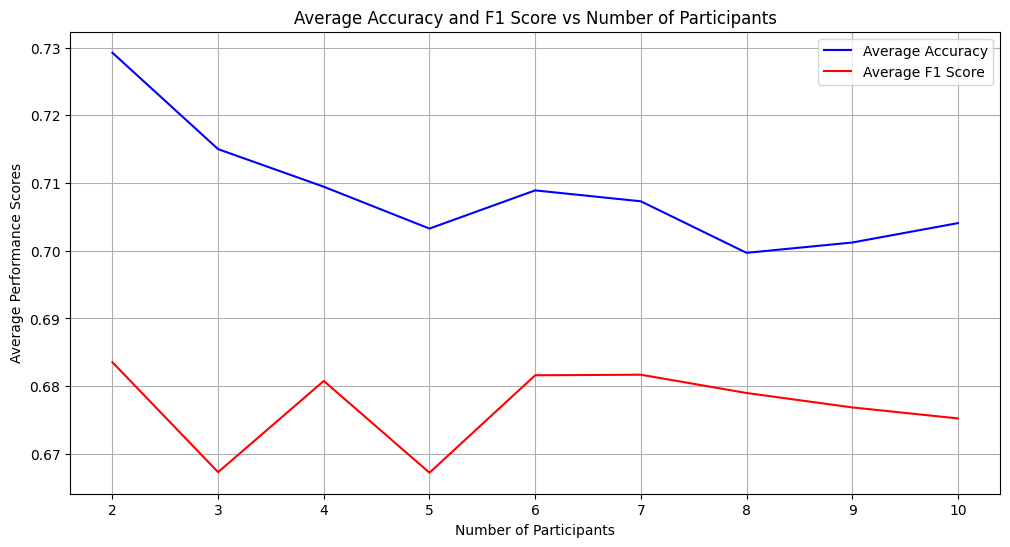

In [ ]:
# Prototype 2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import random

# Seeds for reproducibility
seed = 53
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset loading
df = pd.read_csv("/content/bank.csv")

# Data preprocessing steps
def preprocess_data(df):
    df = df.drop(columns=['duration'])
    label_encoders = {}
    binary_columns = ['default', 'housing', 'loan', 'deposit']
    for column in binary_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

df, label_encoders = preprocess_data(df)

# Vertically partitioning the data "before" one-hot encoding
def vertical_partition(df, num_clients):
    partitions = [[] for _ in range(num_clients)]
    num_features = df.shape[1]

    for i, feature in enumerate(df.columns):
        participant = i % num_clients
        partitions[participant].append(feature)

    partitioned_dfs = [df[features] for features in partitions]
    return partitioned_dfs

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
y_train = train_df['deposit'].values
y_test = test_df['deposit'].values

# Partitions to PyTorch datasets
def create_tensor_datasets(partitions):
    tensor_partitions = []
    for partition in partitions:
        partition = partition.apply(pd.to_numeric, errors='coerce')
        partition = partition.fillna(0)

        for col in partition.select_dtypes(include=['bool']).columns:
            partition[col] = partition[col].astype(int)

        features = partition.drop(columns=["deposit"]).values
        labels = partition["deposit"].values.astype(np.int64)

        tensor_partition = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
        tensor_partitions.append(tensor_partition)
    return tensor_partitions

# GlobalModel class
class GlobalModel(nn.Module):
    def __init__(self, input_sizes, hidden_sizes, output_size):
        super(GlobalModel, self).__init__()
        self.segments = nn.ModuleList()
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
            layers.append(nn.Linear(hidden_size, output_size))
            layers.append(nn.Dropout(p=0.5))
            self.segments.append(nn.Sequential(*layers))

    def forward(self, x, active_segments):
        segment_outputs = []
        hidden_outputs = []  # To store hidden layer outputs for sharing
        start_index = 0
        for i, segment in enumerate(self.segments):
            end_index = start_index + input_sizes[i]
            if i in active_segments:
                segment_input = x[:, start_index:end_index]
                hidden_output = segment[:2](segment_input)  # hidden layer output
                final_output = segment[2](hidden_output)
                hidden_outputs.append(hidden_output)
                segment_outputs.append(final_output)
            else:
                hidden_outputs.append(torch.zeros(x.size(0), hidden_sizes[i], device=x.device))
                segment_outputs.append(torch.zeros(x.size(0), output_size, device=x.device))
            start_index = end_index
        combined_output = torch.mean(torch.stack(segment_outputs), dim=0)
        return combined_output, hidden_outputs

# Class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Updated training function to include hidden layer output sharing
def train(model, device, train_loader, optimizer, epoch, input_sizes, participant_id, hidden_outputs_shared):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)  # Segments not corresponding to the active participant are replaced with zero tensors
        padded_data = torch.zeros(data.size(0), sum(input_sizes)).to(device)
        start_index = sum(input_sizes[:participant_id])
        end_index = start_index + input_sizes[participant_id]
        padded_data[:, start_index:end_index] = data
        optimizer.zero_grad()
        output, hidden_outputs = model(padded_data, active_segments=[participant_id])


        if hidden_outputs_shared is None:
            hidden_outputs_shared = [torch.zeros_like(hidden_output, device=device) for hidden_output in hidden_outputs]

        for layer_id, hidden_output in enumerate(hidden_outputs):
            if layer_id != participant_id:
                if hidden_outputs_shared[layer_id] is not None:
                    hidden_outputs[layer_id] = hidden_outputs_shared[layer_id].to(device)

        loss = nn.CrossEntropyLoss(weight=class_weights)(output, target)
        loss.backward()
        optimizer.step()

        hidden_outputs_shared[:] = hidden_outputs


# Function to exchange gradients and hidden layer outputs
def selective_exchange_gradients_and_hidden(models, input_sizes, hidden_sizes):
    device = models[0].parameters().__next__().device
    num_models = len(models)
    param_indices = [0]
    cumulative_index = 0
    for i in range(len(hidden_sizes)):
        cumulative_index += (input_sizes[i] * hidden_sizes[i]) + hidden_sizes[i]
        param_indices.append(cumulative_index)

    for seg in range(len(hidden_sizes)):
        start = param_indices[seg]
        end = param_indices[seg + 1]
        for param_idx in range(start, end):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad.to(device))
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0).to(device)
                for model in models:
                    model_params = list(model.parameters())
                    if param_idx < len(model_params):
                        model_params[param_idx].grad = avg_grad.clone()

    hidden_outputs_shared = [None for _ in hidden_sizes]
    for model in models:
        _, hidden_outputs = model.forward(torch.zeros(1, sum(input_sizes)).to(device), active_segments=list(range(len(hidden_sizes))))
        for layer_id, hidden_output in enumerate(hidden_outputs):
            hidden_output = hidden_output.to(device)
            if hidden_outputs_shared[layer_id] is None:
                hidden_outputs_shared[layer_id] = hidden_output.clone()
            else:
                hidden_outputs_shared[layer_id] += hidden_output.clone()
        for layer_id in range(len(hidden_outputs_shared)):
            hidden_outputs_shared[layer_id] /= num_models
    return hidden_outputs_shared

# Evaluation function to calculate accuracy and F1 score
def evaluate(models, device, test_loaders, input_sizes):
    for model in models:
        model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_data in zip(*test_loaders):
            data_list = []
            target_list = []
            for participant_id, (data, target) in enumerate(batch_data):
                data_list.append(data)
                target_list.append(target)

            target = target_list[0].to(device)
            for t in target_list:
                assert torch.equal(t, target), "Targets are not consistent across participants"

            data_combined = torch.cat(data_list, dim=1).to(device)

            padded_data = torch.zeros(data_combined.size(0), sum(input_sizes)).to(device)
            start_index = 0
            for participant_id in range(len(input_sizes)):
                end_index = start_index + input_sizes[participant_id]
                if end_index <= data_combined.size(1):
                    padded_data[:, start_index:end_index] = data_combined[:, start_index:end_index]
                else:
                    adjusted_end_index = data_combined.size(1)
                    padded_data[:, start_index:adjusted_end_index] = data_combined[:, start_index:adjusted_end_index]
                start_index = end_index

            outputs = torch.zeros(data_combined.size(0), 2, device=device)
            for model in models:
                output, _ = model(padded_data, active_segments=list(range(len(model.segments))))
                outputs += output
            outputs /= len(models)

            pred = outputs.argmax(dim=1, keepdim=True)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    return accuracy, f1

# Main execution block for 2-10 participant setup
num_seeds = 5
results = {i: {"accuracy": [], "f1": []} for i in range(2, 11)}

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop over seeds
for seed in range(num_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Experiment with participant configurations from 2 to 10
    participant_range = range(2, 11)

    for num_participants in participant_range:
        print(f"Seed: {seed}, Participants: {num_participants}")
        print(f"\n--- Running with {num_participants} Participants ---")

        # Partitions for the current number of participants
        train_partitions = vertical_partition(train_df.drop(columns=['deposit']), num_participants)
        test_partitions = vertical_partition(test_df.drop(columns=['deposit']), num_participants)

        for i in range(len(train_partitions)):
            train_partitions[i]['deposit'] = y_train
            test_partitions[i]['deposit'] = y_test

        for i in range(len(train_partitions)):
            train_partitions[i] = pd.get_dummies(train_partitions[i], drop_first=True)
            test_partitions[i] = pd.get_dummies(test_partitions[i], drop_first=True)

        for i in range(len(train_partitions)):
            train_partitions[i], test_partitions[i] = train_partitions[i].align(test_partitions[i], join='left', axis=1, fill_value=0)

        scaler = StandardScaler()
        for i in range(len(train_partitions)):
            feature_columns = train_partitions[i].columns.difference(['deposit'])
            train_partitions[i][feature_columns] = scaler.fit_transform(train_partitions[i][feature_columns])
            test_partitions[i][feature_columns] = scaler.transform(test_partitions[i][feature_columns])

        train_tensor_partitions = create_tensor_datasets(train_partitions)
        test_tensor_partitions = create_tensor_datasets(test_partitions)

        input_sizes = [partition.shape[1] - 1 for partition in train_partitions]  # minus 1 for 'deposit' column
        hidden_sizes = [10] * num_participants
        output_size = 2

        models = [GlobalModel(input_sizes, hidden_sizes, output_size).to(device) for _ in range(num_participants)]
        optimizers = [optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) for model in models]

        federated_rounds = 20
        epochs_per_round = 10

        best_accuracy = 0
        best_f1 = 0

        hidden_outputs_shared = [None for _ in hidden_sizes]

        for federated_round in range(federated_rounds):
            print(f"Federated Round {federated_round + 1}/{federated_rounds}")
            for participant_id in range(num_participants):
                #print(f"  Training Participant {participant_id + 1}")
                train_loader = DataLoader(train_tensor_partitions[participant_id], batch_size=64, shuffle=True)
                for epoch in range(1, epochs_per_round + 1):
                    train(models[participant_id], device, train_loader, optimizers[participant_id], epoch, input_sizes, participant_id, hidden_outputs_shared)

            hidden_outputs_shared = selective_exchange_gradients_and_hidden(models, input_sizes, hidden_sizes)

            test_loaders = [DataLoader(test_tensor_partitions[i], batch_size=32, shuffle=False) for i in range(num_participants)]
            accuracy, f1 = evaluate(models, device, test_loaders, input_sizes)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
            if f1 > best_f1:
                best_f1 = f1

        results[num_participants]["accuracy"].append(best_accuracy)
        results[num_participants]["f1"].append(best_f1)
        print(f"Best Accuracy for {num_participants} Participants: {best_accuracy:.4f}")
        print(f"Best F1 Score for {num_participants} Participants: {best_f1:.4f}")

# Average results across seeds
avg_accuracies = []
avg_f1_scores = []
participant_range = range(2, 11)
for num_participants in participant_range:
    avg_accuracy = np.mean(results[num_participants]["accuracy"])
    avg_f1 = np.mean(results[num_participants]["f1"])
    avg_accuracies.append(avg_accuracy)
    avg_f1_scores.append(avg_f1)

# Plotting the average accuracy and F1 score over different participant configurations
plt.figure(figsize=(12, 6))
plt.plot(participant_range, avg_accuracies, label='Average Accuracy', color='blue')
plt.plot(participant_range, avg_f1_scores, label='Average F1 Score', color='red')
plt.xlabel('Number of Participants')
plt.ylabel('Average Performance Scores')
plt.title('Average Accuracy and F1 Score vs Number of Participants')
plt.legend(loc='best')
plt.grid(True)
plt.show()




--- Running Non-Federated Training with 2 Participants ---
Training Participant 1
  Participant 1 - Accuracy: 0.7125, F1 Score: 0.6589
Training Participant 2
  Participant 2 - Accuracy: 0.6453, F1 Score: 0.6200
Average Accuracy for 2 Participants: 0.6789
Average F1 Score for 2 Participants: 0.6394

--- Running Non-Federated Training with 3 Participants ---
Training Participant 1
  Participant 1 - Accuracy: 0.6570, F1 Score: 0.6112
Training Participant 2
  Participant 2 - Accuracy: 0.6668, F1 Score: 0.6265
Training Participant 3
  Participant 3 - Accuracy: 0.6744, F1 Score: 0.6767
Average Accuracy for 3 Participants: 0.6661
Average F1 Score for 3 Participants: 0.6381

--- Running Non-Federated Training with 4 Participants ---
Training Participant 1
  Participant 1 - Accuracy: 0.6435, F1 Score: 0.6355
Training Participant 2
  Participant 2 - Accuracy: 0.6350, F1 Score: 0.5947
Training Participant 3
  Participant 3 - Accuracy: 0.6923, F1 Score: 0.6236
Training Participant 4
  Participant

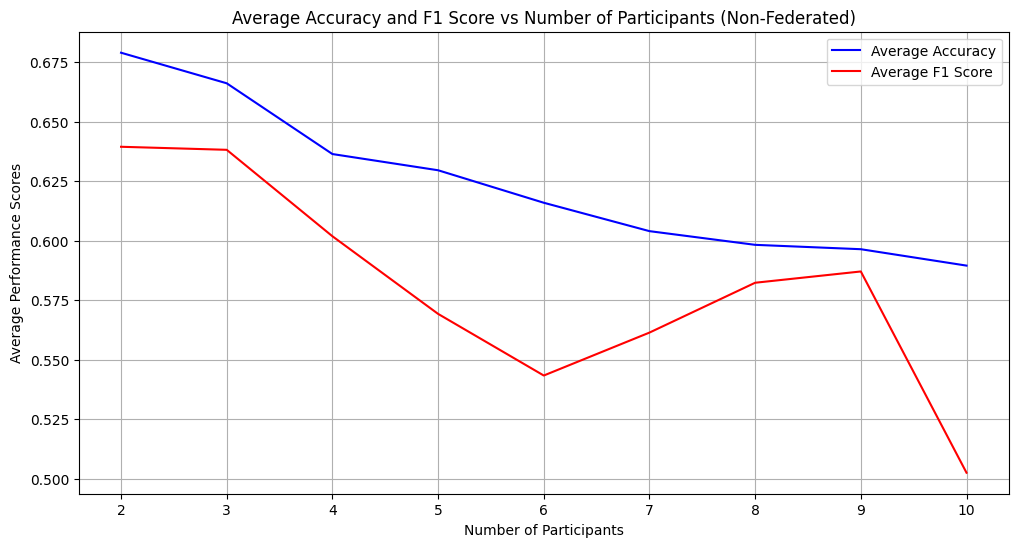

In [ ]:
# No Federation

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import random

# Seeds for reproducibility
seed = 53
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset loading
df = pd.read_csv("/content/bank.csv")

# Data preprocessing steps
def preprocess_data(df):
    df = df.drop(columns=['duration'])
    label_encoders = {}
    binary_columns = ['default', 'housing', 'loan', 'deposit']
    for column in binary_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

df, label_encoders = preprocess_data(df)

# Vertically partitioning the data "before" one-hot encoding
def vertical_partition(df, num_clients):
    partitions = [[] for _ in range(num_clients)]
    num_features = df.shape[1]

    for i, feature in enumerate(df.columns):
        participant = i % num_clients
        partitions[participant].append(feature)

    partitioned_dfs = [df[features] for features in partitions]
    return partitioned_dfs

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
y_train = train_df['deposit'].values
y_test = test_df['deposit'].values

# Partitions to PyTorch datasets
def create_tensor_datasets(partitions):
    tensor_partitions = []
    for partition in partitions:
        partition = partition.apply(pd.to_numeric, errors='coerce')
        partition = partition.fillna(0)

        for col in partition.select_dtypes(include=['bool']).columns:
            partition[col] = partition[col].astype(int)

        features = partition.drop(columns=["deposit"]).values
        labels = partition["deposit"].values.astype(np.int64)

        tensor_partition = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
        tensor_partitions.append(tensor_partition)
    return tensor_partitions

# GlobalModel class
class IndividualModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(IndividualModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Dropout(p=0.5)
        )

    def forward(self, x):
        return self.model(x)

# Class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Training function for individual models (non-federated)
def train_individual(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss(weight=class_weights)(output, target)
        loss.backward()
        optimizer.step()

# Evaluation function for individual models (non-federated)
def evaluate_individual(model, device, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    return accuracy, f1

# Experiment with participant configurations from 2 to 10
participant_range = range(2, 11)
average_accuracies = []
average_f1_scores = []

for num_participants in participant_range:
    print(f"\n--- Running Non-Federated Training with {num_participants} Participants ---")

    # Create partitions for the current number of participants
    train_partitions = vertical_partition(train_df.drop(columns=['deposit']), num_participants)
    test_partitions = vertical_partition(test_df.drop(columns=['deposit']), num_participants)

    for i in range(len(train_partitions)):
        train_partitions[i]['deposit'] = y_train
        test_partitions[i]['deposit'] = y_test

    for i in range(len(train_partitions)):
        train_partitions[i] = pd.get_dummies(train_partitions[i], drop_first=True)
        test_partitions[i] = pd.get_dummies(test_partitions[i], drop_first=True)

    for i in range(len(train_partitions)):
        train_partitions[i], test_partitions[i] = train_partitions[i].align(test_partitions[i], join='left', axis=1, fill_value=0)

    scaler = StandardScaler()
    for i in range(len(train_partitions)):
        feature_columns = train_partitions[i].columns.difference(['deposit'])
        train_partitions[i][feature_columns] = scaler.fit_transform(train_partitions[i][feature_columns])
        test_partitions[i][feature_columns] = scaler.transform(test_partitions[i][feature_columns])

    train_tensor_partitions = create_tensor_datasets(train_partitions)
    test_tensor_partitions = create_tensor_datasets(test_partitions)

    input_sizes = [partition.shape[1] - 1 for partition in train_partitions]  # minus 1 for 'deposit' column
    hidden_size = 10
    output_size = 2

    models = [IndividualModel(input_sizes[i], hidden_size, output_size).to(device) for i in range(num_participants)]
    optimizers = [optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) for model in models]

    epochs = 20

    participant_accuracies = []
    participant_f1_scores = []

    for participant_id in range(num_participants):
        print(f"Training Participant {participant_id + 1}")
        train_loader = DataLoader(train_tensor_partitions[participant_id], batch_size=64, shuffle=True)
        test_loader = DataLoader(test_tensor_partitions[participant_id], batch_size=32, shuffle=False)

        for epoch in range(1, epochs + 1):
            train_individual(models[participant_id], device, train_loader, optimizers[participant_id], epoch)

        accuracy, f1 = evaluate_individual(models[participant_id], device, test_loader)
        participant_accuracies.append(accuracy)
        participant_f1_scores.append(f1)
        print(f"  Participant {participant_id + 1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Average accuracy and F1 score across all participants
    avg_accuracy = np.mean(participant_accuracies)
    avg_f1_score = np.mean(participant_f1_scores)

    average_accuracies.append(avg_accuracy)
    average_f1_scores.append(avg_f1_score)

    print(f"Average Accuracy for {num_participants} Participants: {avg_accuracy:.4f}")
    print(f"Average F1 Score for {num_participants} Participants: {avg_f1_score:.4f}")

# Plotting the average accuracy and F1 score over different participant configurations
plt.figure(figsize=(12, 6))
plt.plot(participant_range, average_accuracies, label='Average Accuracy', color='blue')
plt.plot(participant_range, average_f1_scores, label='Average F1 Score', color='red')
plt.xlabel('Number of Participants')
plt.ylabel('Average Performance Scores')
plt.title('Average Accuracy and F1 Score vs Number of Participants (Non-Federated)')
plt.legend(loc='best')
plt.grid(True)
plt.show()
